# Module 15: Support Vector Machine

This notebook covers the main concepts and implementations of Support Vector Machines (SVM) and Support Vector Regression (SVR). We will move from intuition to real data implementations step by step.


## 15.1 Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons, make_circles, load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score

np.random.seed(42)
plt.rcParams['figure.figsize'] = (6, 4)


## 15.2 Simple Linear SVM on a Toy Dataset
We start with a very small synthetic dataset to see how a linear SVM separates two classes with a margin.


In [2]:
# Generate a simple linearly separable dataset
X_lin, y_lin = make_classification(
    n_samples=200,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=1.8,
    random_state=42,
)

y_lin[:10]  # quick look at labels

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])

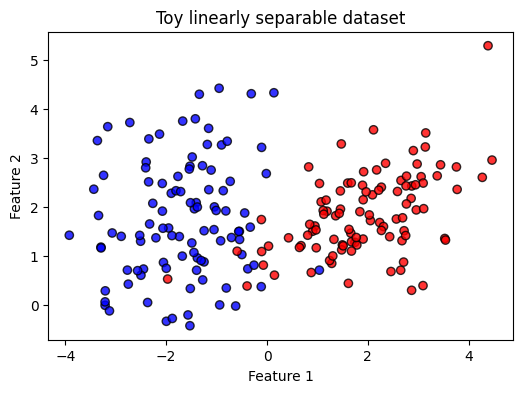

In [3]:
# Visualise the toy dataset
plt.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap='bwr', edgecolors='k', alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy linearly separable dataset')
plt.show()

In [4]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(
    X_lin, y_lin, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Train a linear SVM classifier
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train_scaled, y_train)

y_pred = svm_linear.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.975


In [6]:
# Helper function to plot decision boundary for 2D data
def plot_decision_boundary(model, X, y, title='Decision boundary'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.8)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

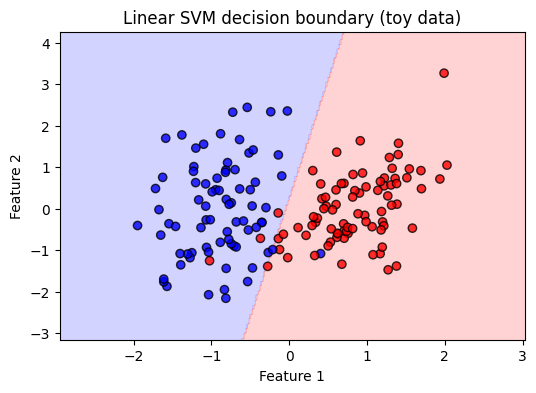

In [7]:
# Visualise the linear SVM boundary on scaled training data
plot_decision_boundary(svm_linear, X_train_scaled, y_train, title='Linear SVM decision boundary (toy data)')

## 15.3 Kernels: Linear, Polynomial, and RBF
In this section we use non linear datasets (moons and circles) to see why kernels are needed and how different kernels behave.


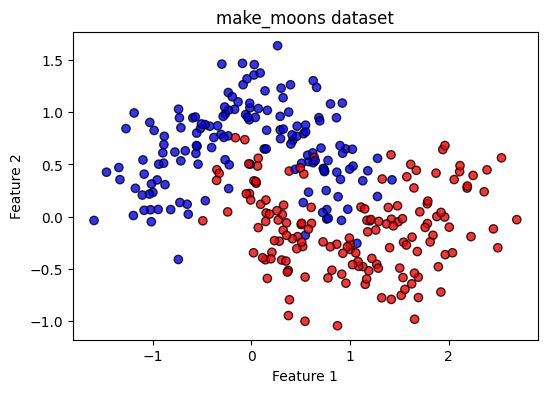

In [8]:
# Generate moons dataset (non linear but simple)
X_moon, y_moon = make_moons(n_samples=300, noise=0.25, random_state=42)

plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap='bwr', edgecolors='k', alpha=0.8)
plt.title('make_moons dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [9]:
# Scale moons data
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(
    X_moon, y_moon, test_size=0.2, random_state=42
)

scaler_moon = StandardScaler()
X_moon_train_scaled = scaler_moon.fit_transform(X_moon_train)
X_moon_test_scaled = scaler_moon.transform(X_moon_test)

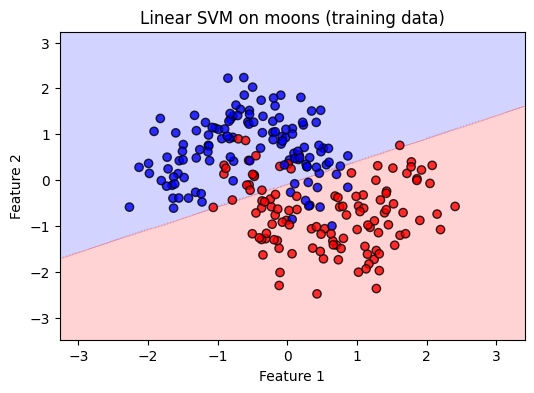

Accuracy (linear kernel on moons): 0.8833333333333333


In [10]:
# Linear kernel on moons
svc_linear_moon = SVC(kernel='linear', C=1.0, random_state=42)
svc_linear_moon.fit(X_moon_train_scaled, y_moon_train)
plot_decision_boundary(svc_linear_moon, X_moon_train_scaled, y_moon_train,
                       title='Linear SVM on moons (training data)')
print('Accuracy (linear kernel on moons):', accuracy_score(y_moon_test,
      svc_linear_moon.predict(X_moon_test_scaled)))

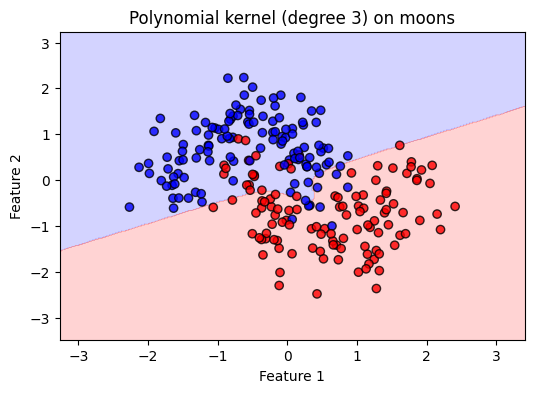

Accuracy (polynomial kernel on moons): 0.9


In [11]:
# Polynomial kernel on moons
svc_poly_moon = SVC(kernel='poly', degree=3, C=20.0, gamma='scale', random_state=42)
svc_poly_moon.fit(X_moon_train_scaled, y_moon_train)
plot_decision_boundary(svc_poly_moon, X_moon_train_scaled, y_moon_train,
                       title='Polynomial kernel (degree 3) on moons')
print('Accuracy (polynomial kernel on moons):', accuracy_score(y_moon_test,
      svc_poly_moon.predict(X_moon_test_scaled)))

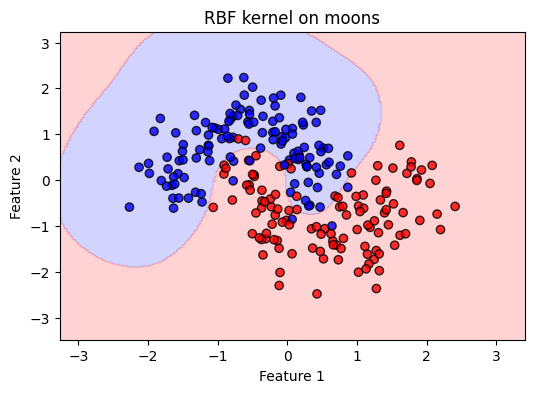

Accuracy (RBF kernel on moons): 0.9166666666666666


In [12]:
# RBF kernel on moons
svc_rbf_moon = SVC(kernel='rbf', C=10.0, gamma=1.0, random_state=42)
svc_rbf_moon.fit(X_moon_train_scaled, y_moon_train)
plot_decision_boundary(svc_rbf_moon, X_moon_train_scaled, y_moon_train,
                       title='RBF kernel on moons')
print('Accuracy (RBF kernel on moons):', accuracy_score(y_moon_test,
      svc_rbf_moon.predict(X_moon_test_scaled)))

## 15.4 SVM Classification on Real Data (Breast Cancer Dataset)
Now we move to a real world dataset: the breast cancer dataset from scikit learn. We will train an SVM classifier and inspect its performance.


In [13]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_bc = cancer.data
y_bc = cancer.target

print('Feature shape:', X_bc.shape)
print('Classes:', cancer.target_names)

Feature shape: (569, 30)
Classes: ['malignant' 'benign']


In [14]:
# Train test split and scaling
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc
)

scaler_bc = StandardScaler()
X_bc_train_scaled = scaler_bc.fit_transform(X_bc_train)
X_bc_test_scaled = scaler_bc.transform(X_bc_test)

In [15]:
# Train an RBF SVM classifier on breast cancer data
svc_bc = SVC(kernel='rbf', C=1.0, gamma = 'scale', random_state=42)
svc_bc.fit(X_bc_train_scaled, y_bc_train)

y_bc_pred = svc_bc.predict(X_bc_test_scaled)
acc_bc = accuracy_score(y_bc_test, y_bc_pred)
print("Accuracy with RBF: ", acc_bc)

print('\nClassification report:')
print(classification_report(y_bc_test, y_bc_pred, target_names=cancer.target_names))

Accuracy with RBF:  0.9824561403508771

Classification report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [16]:
# Confusion matrix
cm = confusion_matrix(y_bc_test, y_bc_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[41  1]
 [ 1 71]]


## 15.5 Effect of Hyperparameters C and gamma
In SVM with RBF kernel, the parameter C controls the softness of the margin and gamma controls how far a point influences the decision boundary.


In [17]:
def evaluate_svm_c_gamma(X_train, X_test, y_train, y_test, C_values, gamma_values):
    results = []
    for C in C_values:
        for gamma in gamma_values:
            model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results.append({'C': C, 'gamma': gamma, 'accuracy': acc})
    return pd.DataFrame(results)

C_values = [0.1, 1.0, 10.0]
gamma_values = ['scale', 0.01, 0.1, 1.0]

df_hyper = evaluate_svm_c_gamma(X_bc_train_scaled, X_bc_test_scaled,
                                y_bc_train, y_bc_test,
                                C_values, gamma_values)
df_hyper

,C,gamma,accuracy
0,0.1,scale,0.947368
1,0.1,0.01,0.956140
2,0.1,0.1,0.947368
3,0.1,1.0,0.631579
4,1.0,scale,0.982456
5,1.0,0.01,0.982456
6,1.0,0.1,0.956140
7,1.0,1.0,0.631579
8,10.0,scale,0.973684
9,10.0,0.01,0.982456


In [18]:
# Sort by accuracy to see top combinations
df_hyper.sort_values('accuracy', ascending=False)

,C,gamma,accuracy
5,1.0,0.01,0.982456
9,10.0,0.01,0.982456
4,1.0,scale,0.982456
8,10.0,scale,0.973684
6,1.0,0.1,0.956140
1,0.1,0.01,0.956140
0,0.1,scale,0.947368
2,0.1,0.1,0.947368
10,10.0,0.1,0.947368
3,0.1,1.0,0.631579


## 15.6 Introduction to Support Vector Regression (SVR)
Support Vector Regression applies the same maximum margin idea to regression. Instead of a margin between classes, we use an epsilon tube around the regression line.


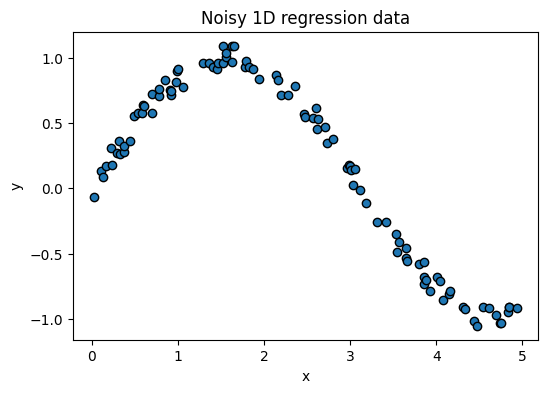

In [19]:
# Create a simple 1D regression dataset
rng = np.random.RandomState(42)
X_reg = np.sort(5 * rng.rand(100, 1), axis=0)
y_reg = np.sin(X_reg).ravel()

# Add some noise
y_reg += 0.2 * (rng.rand(y_reg.shape[0]) - 0.5)

plt.scatter(X_reg, y_reg, edgecolors='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy 1D regression data')
plt.show()

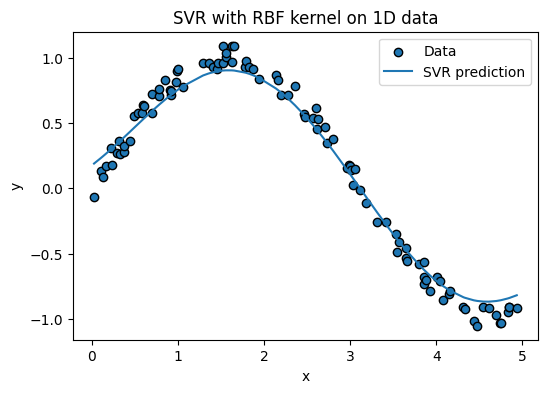

In [20]:
# Train an SVR with RBF kernel
svr_rbf = SVR(kernel='rbf', C=0.1, epsilon= 0.1, gamma = 'scale')
svr_rbf.fit(X_reg, y_reg)

y_reg_pred = svr_rbf.predict(X_reg)

plt.scatter(X_reg, y_reg, edgecolors='k', label='Data')
plt.plot(X_reg, y_reg_pred, label='SVR prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('SVR with RBF kernel on 1D data')
plt.legend()
plt.show()

In [21]:
# Evaluate SVR with MSE and R^2
mse = mean_squared_error(y_reg, y_reg_pred)
r2 = r2_score(y_reg, y_reg_pred)

print("MSE: ", mse)
print("R^2: ",r2)

MSE:  0.008659453875945123
R^2:  0.9818609249737438


## 15.7 SVR on Real Data (Diabetes Dataset)
We now apply SVR on a real dataset from scikit learn. This shows how it behaves on tabular regression data.


In [22]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diab = diabetes.data
y_diab = diabetes.target

print('Feature shape:', X_diab.shape)

Feature shape: (442, 10)


In [23]:
# Train test split and scaling
X_diab_train, X_diab_test, y_diab_train, y_diab_test = train_test_split(
    X_diab, y_diab, test_size=0.2, random_state=42
)

scaler_diab = StandardScaler()
X_diab_train_scaled = scaler_diab.fit_transform(X_diab_train)
X_diab_test_scaled = scaler_diab.transform(X_diab_test)

In [24]:
# Train SVR on diabetes data
svr_diab = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale')
svr_diab.fit(X_diab_train_scaled, y_diab_train)

y_diab_pred = svr_diab.predict(X_diab_test_scaled)

mse_diab = mean_squared_error(y_diab_test, y_diab_pred)
r2_diab = r2_score(y_diab_test, y_diab_pred)

print("MSE: ", mse_diab)
print("R^2: ", r2_diab)

MSE:  2682.387949725229
R^2:  0.4937125101265256


## 15.8 Summary
In this notebook we:
- Built intuition for linear SVM on toy data.
- Saw why kernels are needed with non linear mooon data.
- Trained SVM classifiers on a real breast cancer dataset.
- Explored the effect of C and gamma hyperparameters.
- Introduced SVR and visualised it on 1D data.
- Applied SVR on a real diabetes regression dataset.

This covers the implementation backbone for Module 15.
